In [1]:
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

In [2]:
NUMBER_OF_SAMPLES  = 60000
NUBMER_OF_TESTS = 10000
(trainX, trainY), (testX, testY) = mnist.load_data()
trainX, trainY = trainX[:NUMBER_OF_SAMPLES], trainY[:NUMBER_OF_SAMPLES]
testX, testY = testX[:NUBMER_OF_TESTS], testY[:NUBMER_OF_TESTS]
trainX = trainX.reshape(trainX.shape[0], 28**2) / 255.0
testX = testX.reshape(testX.shape[0], 28**2) / 255.0
trainX.shape, trainY.shape, testX.shape, testY.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [3]:
def ReLU(x):
    return np.maximum(0, x)

def dReLU(x):
    return np.where(x > 0, 1, 0)

def softmax(x):
    shiftx = x - np.max(x)
    exps = np.exp(shiftx)
    return exps / np.sum(exps)

def dsoftmax(x):
    s = softmax(x)
    return np.diagflat(s) - np.outer(s, s)

def MSE(y, y_ref):
    return 0.5 * np.mean((y - y_ref)**2)

def dMSE(y, y_ref):
    delta = y - y_ref
    return delta / delta.size

def KL_divergence(y, y_ref):
    return np.mean(y_ref * np.log((y_ref + 1e-9) / (y + 1e-9)))

def KL_divergence_derivative(y, y_ref):
    return -y_ref / (y + 1e-9)

def categorical_cross_entropy(y, y_ref):
    return -np.mean(y_ref * np.log(y + 1e-9))

def categorical_cross_entropy_derivative(y, y_ref):
   return y - y_ref


In [5]:
class Perceptron:
    def __init__(self, input_neurons, hidden_neurons, output_neurons,  hidden_layers_count, epochs=16, learning_rate=0.003):
        self.initial_weights = []
        self.initial_biases = []
        self.activation_functions = []
        self.activation_derivatives = []
        self.epochs = epochs
        self.learning_rate = learning_rate
        layers = [input_neurons] + [hidden_neurons] * hidden_layers_count + [output_neurons]
        for i in range(1, len(layers)):
            W = np.random.randn(layers[i - 1], layers[i]) * 0.3
            b = np.zeros(layers[i])
            self.initial_weights.append(W)
            self.initial_biases.append(b)
            self.activation_functions.append(ReLU)
            self.activation_derivatives.append(dReLU)
        self.activation_functions[-1] = softmax
        self.activation_derivatives[-1] = dsoftmax

    def predict(self, x):
        activation = x
        for W, b, f in zip(self.weights, self.biases, self.activation_functions):
            activation = f(np.dot(activation, W) + b)
        return int(np.argmax(activation))
    
    def set_learning_rate(self, learning_rate):
        self.learning_rate = learning_rate

    def set_epochs(self, epochs):
        self.epochs = epochs
    
    def forward_and_backward(self, x, y_ref, loss_function, dloss_function):
        grads_w = [None] * len(self.weights)
        grads_b = [None] * len(self.biases)
        activations = [x]
        inputs = []
        for (W, b, f) in zip(self.weights, self.biases, self.activation_functions):
            weighted_sum = np.dot(activations[-1], W) + b
            inputs.append(weighted_sum)
            activations.append(f(weighted_sum))

        y = activations[-1]
        loss = loss_function(y, y_ref)
        delta_loss = dloss_function(y, y_ref)
        dZ = np.dot(delta_loss, dsoftmax(inputs[-1]))
        grads_w[-1] = np.outer(activations[-2], dZ)
        grads_b[-1] = dZ

        for i in range(len(self.weights) - 2, -1, -1):
            dA = np.dot(dZ, self.weights[i + 1].T)
            dZ = dA * self.activation_derivatives[i](inputs[i])
            grads_w[i] = np.outer(activations[i], dZ)
            grads_b[i] = dZ

        return grads_w, grads_b, loss
    
    def validate(self, X, Y, loss_function):
        correct_predictions = 0
        total_loss = 0.0
        for (x, y_ref) in zip(X, Y):
            activation = x
            for W, b, f in zip(self.weights, self.biases, self.activation_functions):
                activation = f(np.dot(activation, W) + b)
            total_loss +=  loss_function(activation, y_ref)

            if int(np.argmax(activation)) == np.argmax(y_ref):
                correct_predictions += 1
        return total_loss / len(X), correct_predictions / len(X)

    def train(self, trainX, trainY, validate_X, validate_Y, loss_function, dloss_function):
        train_one_hot = np.array([np.array([int(i == y) for i in range(10)]) for y in trainY])
        validate_one_hot = np.array([np.array([int(i == y) for i in range(10)]) for y in validate_Y])
        self.weights = [np.copy(w) for w in self.initial_weights]
        self.biases = [np.copy(b) for b in self.initial_biases]
        loss, accuracy = self.validate(validate_X, validate_one_hot, loss_function)
        losses = [loss]
        accuracies = [accuracy]
        for epoch in range(self.epochs):
            for (x, y_ref) in zip(trainX, train_one_hot):
                weight_grads, bias_grads, loss = self.forward_and_backward(
                    x, 
                    y_ref,
                    loss_function, 
                    dloss_function
                )

                for i in range(len(self.weights)):
                    self.weights[i] -= weight_grads[i] * self.learning_rate
                    self.biases[i] -= bias_grads[i] * self.learning_rate
            loss, accuracy = self.validate(validate_X, validate_one_hot, loss_function)
            losses.append(loss)
            accuracies.append(accuracy)

        return losses, accuracies


In [6]:
def launch(number_of_neurons, number_of_layers, epochs, learging_rate):
    epochs_axis = np.arange(epochs + 1)

    perceptron = Perceptron(28**2, number_of_neurons, 10, number_of_layers, epochs, learging_rate)

    mse_loss, mse_accuracy = perceptron.train(trainX, trainY, testX, testY, MSE, dMSE)

    cross_entropy_loss, cross_entropy_accuracy = perceptron.train(trainX, trainY, testX, testY,categorical_cross_entropy, categorical_cross_entropy_derivative)

    KL_divergence_loss, KL_divergence_accuracy = perceptron.train(trainX, trainY, testX, testY, KL_divergence, KL_divergence_derivative)
    
    plt.figure()
    plt.title(f"Зависимость функции потерь от количества эпох (скрытых слоев: {number_of_layers}, нейронов: {number_of_neurons})")
    plt.xlabel("Количество эпох")
    plt.ylabel("Значение функции потерь")
    plt.plot(epochs_axis, mse_loss, label = "MSE")
    plt.plot(epochs_axis, cross_entropy_loss, label = "Categorical cross entropy")
    plt.plot(epochs_axis, KL_divergence_loss, label = "KL divergence")
    plt.legend()
    plt.show()

    plt.figure()
    plt.title(f"Зависимость точности от количества эпох (скрытых слоев: {number_of_layers}, нейронов: {number_of_neurons})")
    plt.xlabel("Количество эпох")
    plt.ylabel("Точность")
    plt.plot(epochs_axis, mse_accuracy, label = "MSE")
    plt.plot(epochs_axis, cross_entropy_accuracy, label = "Categorical cross entropy")
    plt.plot(epochs_axis, KL_divergence_accuracy, label = "KL divergence")
    plt.legend()
    plt.show()

    return

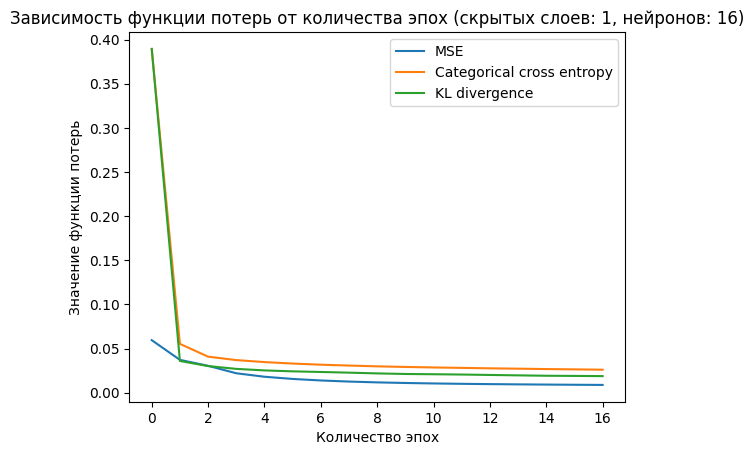

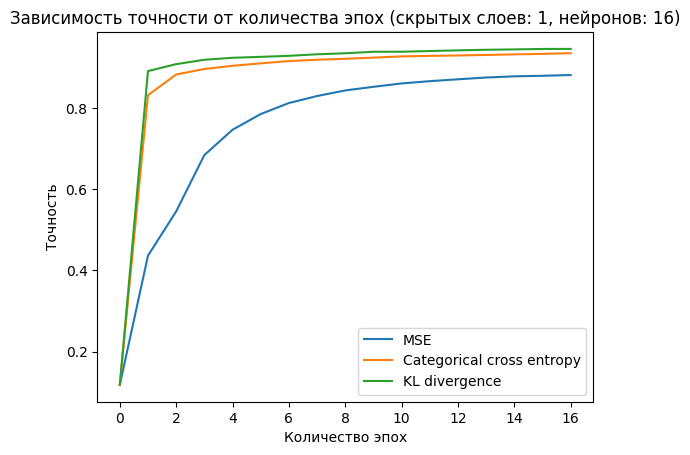

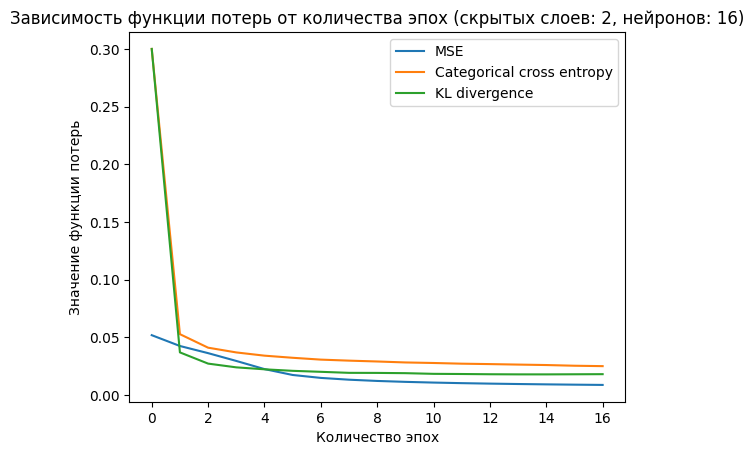

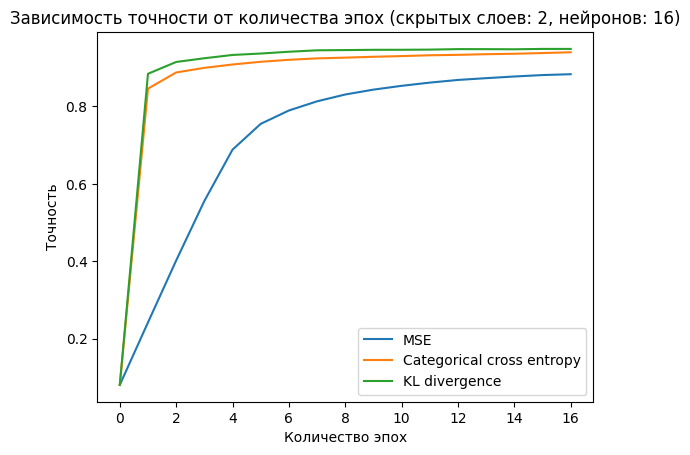

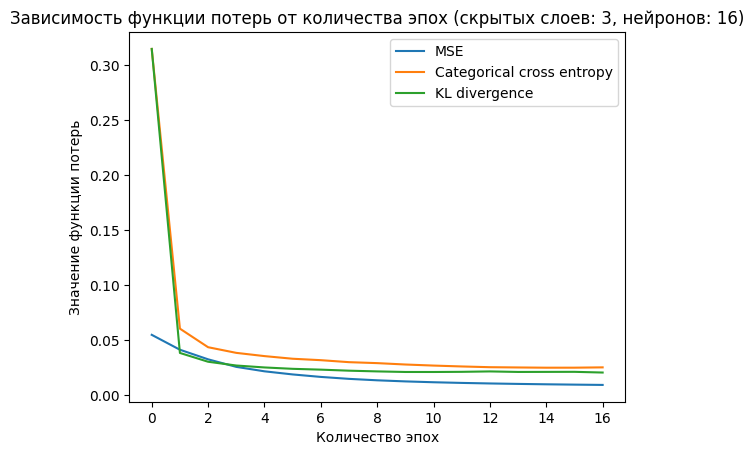

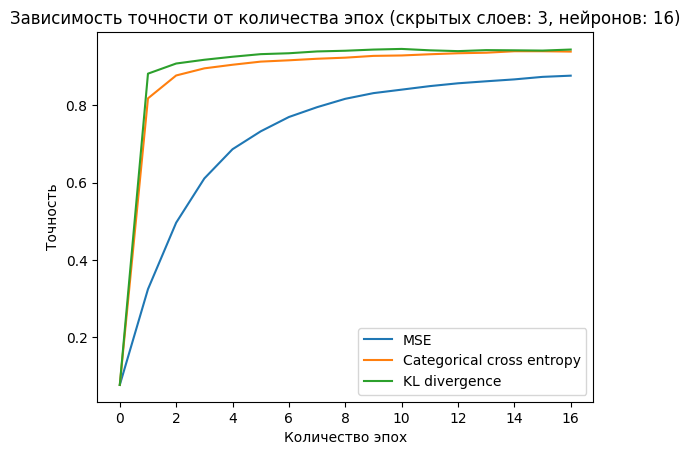

In [7]:
for number_of_layers in [1, 2, 3]:
    launch(16, number_of_layers, 16, 0.003)   